<a href="https://colab.research.google.com/github/BMM52/Tata-Steel-Machine-Faiure-Prediction-/blob/main/Tata_Steel_Machine_Failure_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tata Steel Machine Failure Prediction 🚧⚙️

## 1. Project Overview

In the manufacturing sector, **unplanned machine failures** cause:

- Production downtime  
- High maintenance costs  
- Delays in delivery  
- Potential safety risks  

**TATA Steel** wants to leverage data and machine learning to **predict machine failures in advance**, so that maintenance can be **planned proactively** instead of reactively.

### 🎯 Objective

> Build a **supervised machine learning model** that predicts whether a machine will fail during operation based on its operating conditions and tool wear.

The model should:

- **Maximize Recall** for the failure class (catch as many failures as possible)  
- While keeping **Precision reasonable** (avoid too many false alarms)  
- Be interpretable enough to explain **which parameters most affect failures**

---

## 2. Dataset Description

The dataset is synthetically generated based on real-world steel manufacturing machines.

### Key Columns

- `Type` — Machine type: L, M, H  
- `Air temperature [K]` — Ambient temperature  
- `Process temperature [K]` — Internal process temperature  
- `Rotational speed [rpm]` — Spindle speed  
- `Torque [Nm]` — Torque measured  
- `Tool wear [min]` — Tool wear in minutes  
- `Machine failure` — Target label (1 = failure, 0 = no failure)

### Failure Type Columns (in train & test)

- `TWF` — Tool Wear Failure  
- `HDF` — Heat Dissipation Failure  
- `PWF` — Power Failure  
- `OSF` — Overstrain Failure  
- `RNF` — Random Failure  

> ⚠️ These are NOT used as input features, because they describe **types of failure**, not machine conditions before failure. Using them as features would cause **data leakage**.

---

## 3. High-Level Workflow

1. Load train & test data  
2. Basic data checks and EDA  
3. Feature engineering  
4. Train–validation split  
5. Preprocessing (scaling + encoding)  
6. Model training & comparison  
   - Baseline: Logistic Regression  
   - Final: Tuned XGBoost  
7. Threshold tuning (optimizing for recall vs precision)  
8. SHAP-based model explainability  
9. Final training on full train + predictions on test  
10. Business-oriented conclusion


In [1]:
# ===========================================
# 2. SETUP: Imports, Config, Utility Functions
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# ===========================================
# 3. LOAD TRAIN & TEST DATA
# ===========================================

train_url = "https://raw.githubusercontent.com/BMM52/Tata-Steel-Machine-Faiure-Prediction-/refs/heads/main/train.csv"
test_url  = "https://raw.githubusercontent.com/BMM52/Tata-Steel-Machine-Faiure-Prediction-/refs/heads/main/test.csv"

try:
    df_train_raw = pd.read_csv(train_url)
    df_test_raw  = pd.read_csv(test_url)
    print("✅ Data successfully loaded from GitHub.")
except Exception as e:
    print("❌ Error loading data:", e)

print("\nTrain shape:", df_train_raw.shape)
print("Test shape :", df_test_raw.shape)

df_train_raw.head()


✅ Data successfully loaded from GitHub.

Train shape: (136429, 14)
Test shape : (90954, 13)


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


## 4. Data Understanding

Here we:

- Inspect columns & data types  
- Check for missing values  
- Inspect class imbalance  
- Inspect failure type columns  


In [3]:
# ===========================================
# 4.1 BASIC INFO & NULL CHECKS
# ===========================================
print("=== TRAIN INFO ===")
print(df_train_raw.info())

print("\n=== TRAIN NULL VALUES ===")
print(df_train_raw.isna().sum())

print("\n=== TEST INFO ===")
print(df_test_raw.info())

print("\n=== TEST NULL VALUES ===")
print(df_test_raw.isna().sum())


=== TRAIN INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null

Class counts:
 Machine failure
0    134281
1      2148
Name: count, dtype: int64

Class %:
 Machine failure
0    98.43
1     1.57
Name: proportion, dtype: float64


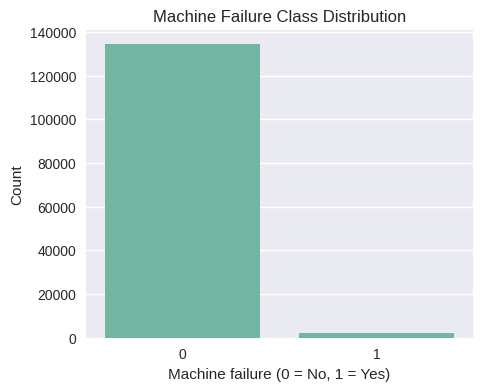

In [4]:
# ===========================================
# 4.2 TARGET DISTRIBUTION (Machine failure)
# ===========================================
target_col = "Machine failure"

failure_counts = df_train_raw[target_col].value_counts()
failure_perc   = df_train_raw[target_col].value_counts(normalize=True) * 100

print("Class counts:\n", failure_counts)
print("\nClass %:\n", failure_perc.round(2))

plt.figure(figsize=(5,4))
sns.barplot(x=failure_counts.index.astype(str), y=failure_counts.values)
plt.title("Machine Failure Class Distribution")
plt.xlabel("Machine failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [5]:
# ===========================================
# 4.3 FAILURE TYPE DISTRIBUTIONS
# ===========================================
failure_type_cols = ["TWF", "HDF", "PWF", "OSF", "RNF"]

for col in failure_type_cols:
    print(f"\n==== {col} ====")
    counts = df_train_raw[col].value_counts()
    perc   = df_train_raw[col].value_counts(normalize=True) * 100
    print("Counts:\n", counts)
    print("Percentage:\n", perc.round(2))



==== TWF ====
Counts:
 TWF
0    136217
1       212
Name: count, dtype: int64
Percentage:
 TWF
0    99.84
1     0.16
Name: proportion, dtype: float64

==== HDF ====
Counts:
 HDF
0    135725
1       704
Name: count, dtype: int64
Percentage:
 HDF
0    99.48
1     0.52
Name: proportion, dtype: float64

==== PWF ====
Counts:
 PWF
0    136102
1       327
Name: count, dtype: int64
Percentage:
 PWF
0    99.76
1     0.24
Name: proportion, dtype: float64

==== OSF ====
Counts:
 OSF
0    135889
1       540
Name: count, dtype: int64
Percentage:
 OSF
0    99.6
1     0.4
Name: proportion, dtype: float64

==== RNF ====
Counts:
 RNF
0    136121
1       308
Name: count, dtype: int64
Percentage:
 RNF
0    99.77
1     0.23
Name: proportion, dtype: float64


## 5. Feature Engineering

We will remove non-predictive or leakage-prone columns and create **physically meaningful features**.

### ❌ Columns to Drop

From `train`:

- `id` — Just a row identifier  
- `Product ID` — Encodes product, but not necessary for generalization  
- `TWF`, `HDF`, `PWF`, `OSF`, `RNF` — Describe failure *types*, not pre-failure conditions

From `test` (as features):

- `Product ID`, `TWF`, `HDF`, `PWF`, `OSF`, `RNF` (keep `id` only for submission)

### ✅ Engineered Features

1. **`temp_diff`** = `Process temperature [K]` – `Air temperature [K]`  
   - Higher difference → more heat buildup → risk of failure  

2. **`torque_per_rpm`** = `Torque [Nm]` / `Rotational speed [rpm]`  
   - Captures mechanical stress  

3. **`temp_ratio`** = `Process temperature [K]` / `Air temperature [K]`  
   - Efficiency of heat dissipation  

4. **`high_wear_flag`** = 1 if `Tool wear [min]` > 150 else 0  
   - Flag highly worn tools  

5. **`temp_interaction`** = `Air temperature [K]` × `Process temperature [K]`  
   - Interaction between internal and external temperature


In [6]:
# ===========================================
# 5.1 COPY RAW DATA FOR PROCESSING
# ===========================================
df_train = df_train_raw.copy()
df_test  = df_test_raw.copy()

# ===========================================
# 5.2 DROP NON-PREDICTIVE / LEAKAGE COLUMNS
# ===========================================
drop_cols_train = ["id", "Product ID"] + failure_type_cols
drop_cols_test  = ["Product ID"] + failure_type_cols

df_train = df_train.drop(columns=drop_cols_train)
df_test_features = df_test.drop(columns=drop_cols_test)  # keep id separately for submission

print("Train shape after drop:", df_train.shape)
print("Test feature shape after drop:", df_test_features.shape)


Train shape after drop: (136429, 7)
Test feature shape after drop: (90954, 7)


In [7]:
# ===========================================
# 5.3 FEATURE ENGINEERING FUNCTION
# ===========================================
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["temp_diff"] = df["Process temperature [K]"] - df["Air temperature [K]"]
    df["torque_per_rpm"] = df["Torque [Nm]"] / df["Rotational speed [rpm]"].replace(0, 1)
    df["temp_ratio"] = df["Process temperature [K]"] / df["Air temperature [K]"]
    df["high_wear_flag"] = (df["Tool wear [min]"] > 150).astype(int)
    df["temp_interaction"] = df["Air temperature [K]"] * df["Process temperature [K]"]
    return df

df_train = add_engineered_features(df_train)
df_test_features = add_engineered_features(df_test_features)

print("Train columns after feature engineering:\n", df_train.columns.tolist())
df_train.head()


Train columns after feature engineering:
 ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'temp_diff', 'torque_per_rpm', 'temp_ratio', 'high_wear_flag', 'temp_interaction']


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,temp_diff,torque_per_rpm,temp_ratio,high_wear_flag,temp_interaction
0,L,300.6,309.6,1596,36.1,140,0,9.0,0.022619,1.029940,0,93065.76
1,M,302.6,312.1,1759,29.1,200,0,9.5,0.016543,1.031395,1,94441.46
2,L,299.3,308.5,1805,26.5,25,0,9.2,0.014681,1.030738,0,92334.05
3,L,301.0,310.9,1524,44.3,197,0,9.9,0.029068,1.032890,1,93580.90
4,M,298.0,309.0,1641,35.4,34,0,11.0,0.021572,1.036913,0,92082.00


## 6. Exploratory Data Analysis (EDA) — Key Features

We’ll do light but meaningful EDA:

- Distributions of main numeric features  
- Relationship of features with `Machine failure`  
- Correlation matrix  


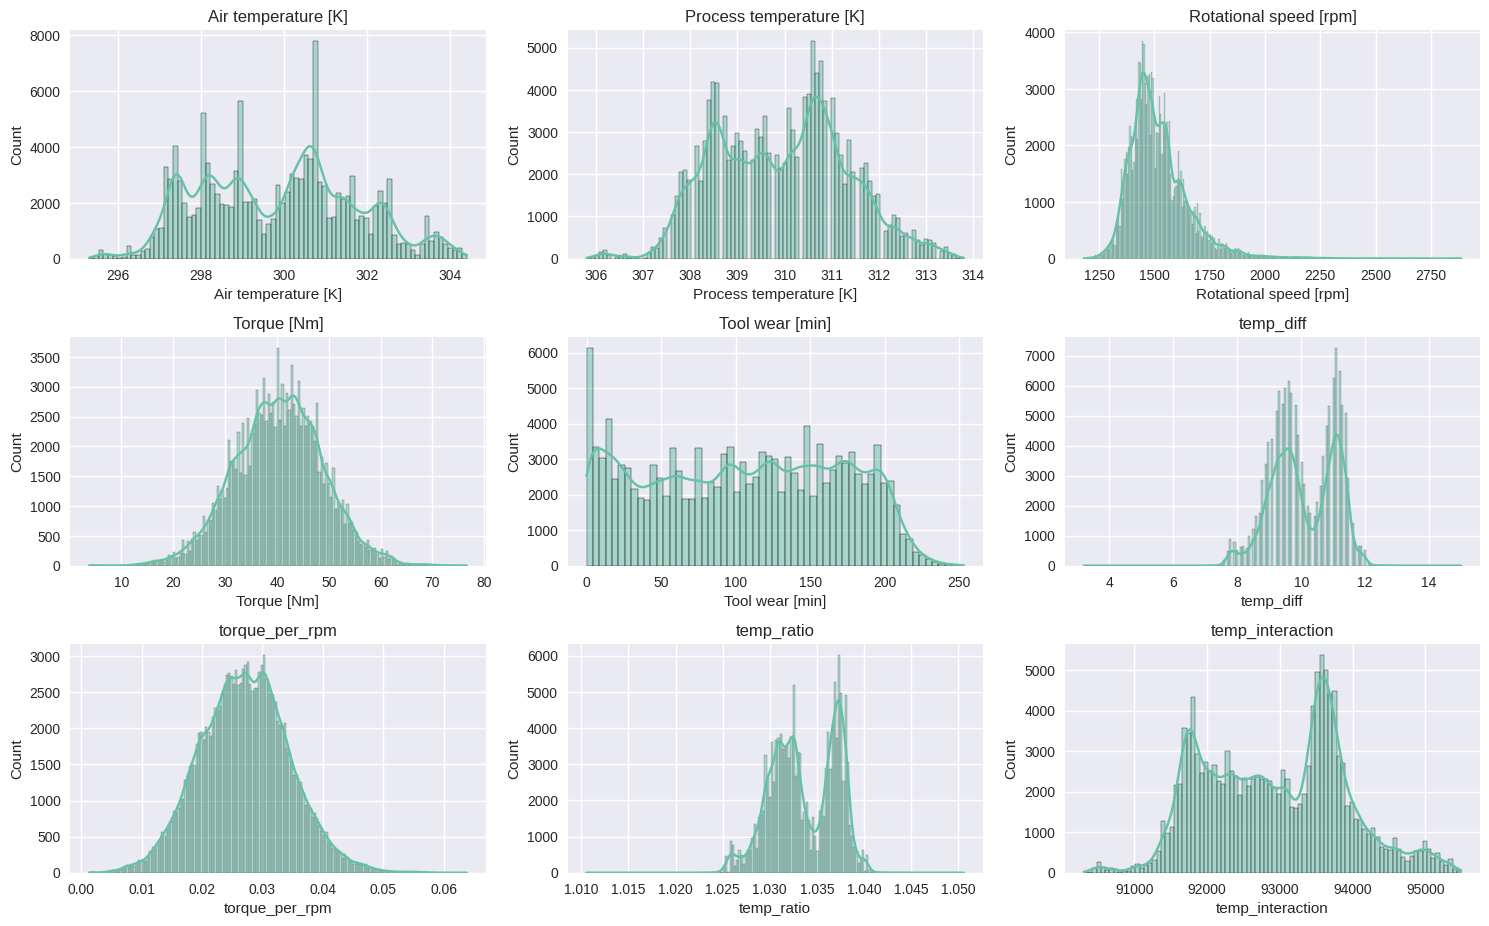

In [8]:
# ===========================================
# 6.1 NUMERIC DISTRIBUTIONS
# ===========================================
numeric_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
    "temp_diff",
    "torque_per_rpm",
    "temp_ratio",
    "temp_interaction"
]

fig, axes = plt.subplots(len(numeric_cols)//3 + 1, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df_train[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


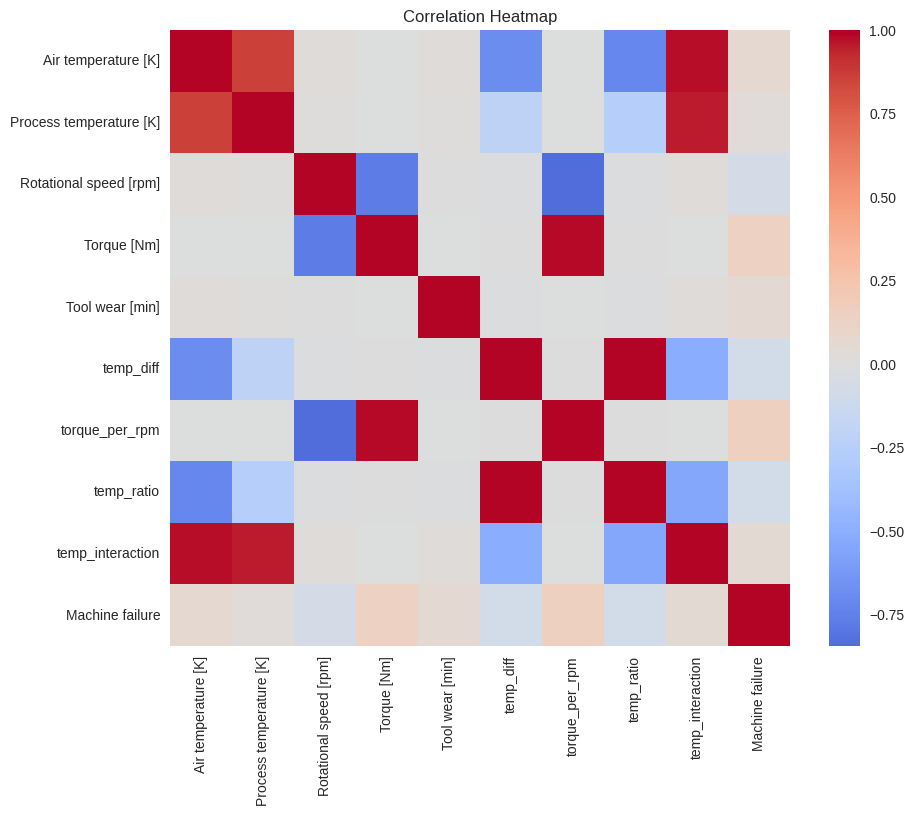

In [9]:
# ===========================================
# 6.2 CORRELATION MATRIX
# ===========================================
corr = df_train[numeric_cols + [target_col]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


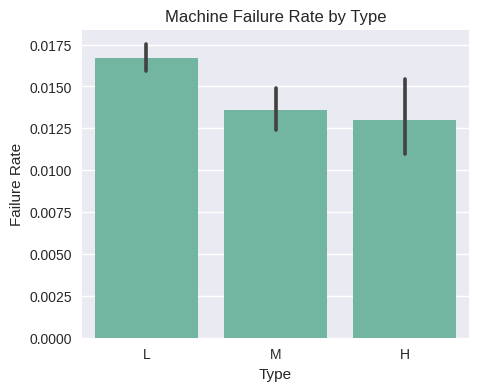

In [10]:
# ===========================================
# 6.3 FAILURE RATE BY MACHINE TYPE
# ===========================================
plt.figure(figsize=(5,4))
sns.barplot(x="Type", y=target_col, data=df_train, estimator=np.mean)
plt.ylabel("Failure Rate")
plt.title("Machine Failure Rate by Type")
plt.show()


## 7. Train–Validation Split & Preprocessing

We will:

- Separate **features (X)** and **target (y)**  
- Define:
  - **Categorical features** → One-Hot Encoding  
  - **Numerical features** → Standard Scaling  
- Use **ColumnTransformer** inside a **Pipeline**  
- Split into **train (80%)** and **validation (20%)** with **stratified sampling** to respect class imbalance.


In [11]:
# ===========================================
# 7.1 SPLIT FEATURES & TARGET
# ===========================================
target = target_col

X = df_train.drop(columns=[target])
y = df_train[target]

cat_features = ["Type"]
num_features = [col for col in X.columns if col not in cat_features]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# ===========================================
# 7.2 TRAIN–VALIDATION SPLIT
# ===========================================
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_val shape  :", X_val.shape)
print("\nTrain target distribution:\n", y_train.value_counts(normalize=True))


Numeric features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'torque_per_rpm', 'temp_ratio', 'high_wear_flag', 'temp_interaction']
Categorical features: ['Type']
X_train shape: (109143, 11)
X_val shape  : (27286, 11)

Train target distribution:
 Machine failure
0    0.984259
1    0.015741
Name: proportion, dtype: float64


In [12]:
# ===========================================
# 7.3 PREPROCESSOR (SCALING + ENCODING)
# ===========================================
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    drop="first",
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop"
)

# Fit preprocessor on training data only
preprocessor.fit(X_train)

# Transform train & validation
X_train_prep = preprocessor.transform(X_train)
X_val_prep   = preprocessor.transform(X_val)

# Build feature names
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(cat_features))
final_feature_names = num_features + ohe_feature_names

print("Preprocessed train shape:", X_train_prep.shape)
print("Preprocessed val shape  :", X_val_prep.shape)
print("\nFinal feature names:\n", final_feature_names)


Preprocessed train shape: (109143, 12)
Preprocessed val shape  : (27286, 12)

Final feature names:
 ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'torque_per_rpm', 'temp_ratio', 'high_wear_flag', 'temp_interaction', 'Type_L', 'Type_M']


## 8. Baseline Model — Logistic Regression

Before using complex models, we start with a simple **Logistic Regression** baseline to understand the difficulty of the problem.

We will use:

- `class_weight="balanced"` to handle class imbalance.  


In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)

log_reg.fit(X_train_prep, y_train)

y_val_pred_lr = log_reg.predict(X_val_prep)
y_val_proba_lr = log_reg.predict_proba(X_val_prep)[:, 1]

print("=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_lr))
print("Precision:", precision_score(y_val, y_val_pred_lr, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_lr, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_lr, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_lr))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_lr, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_lr))


=== Logistic Regression Metrics ===
Accuracy : 0.8406142344059224
Precision: 0.07281447569217353
Recall   : 0.7767441860465116
F1-score : 0.13314729918277857
ROC-AUC  : 0.87043776974181

Classification Report:
              precision    recall  f1-score   support

           0     0.9958    0.8416    0.9122     26856
           1     0.0728    0.7767    0.1331       430

    accuracy                         0.8406     27286
   macro avg     0.5343    0.8092    0.5227     27286
weighted avg     0.9812    0.8406    0.9000     27286

Confusion Matrix:
[[22603  4253]
 [   96   334]]


In [14]:
# ===========================================
# 8.1 MODEL COMPARISON: LR vs RF vs XGBoost (baseline)
# ===========================================

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# We will use the already preprocessed data:
# X_train_prep, X_val_prep, y_train, y_val

# Recompute imbalance ratio for scale_pos_weight
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
imbalance_ratio = num_neg / num_pos
print(f"Imbalance ratio (neg/pos): {imbalance_ratio:.2f}")

models = {}

# 1️⃣ Logistic Regression (baseline)
models["Logistic Regression"] = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)

# 2️⃣ Random Forest (tree-based, handles non-linearity)
models["Random Forest"] = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 3️⃣ XGBoost (baseline, NOT tuned yet)
models["XGBoost (baseline)"] = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=imbalance_ratio
)

results = []

for name, model in models.items():
    print(f"\n================ Training {name} ================")
    model.fit(X_train_prep, y_train)

    # Predictions & probabilities
    y_val_pred = model.predict(X_val_prep)
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val_prep)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)
    else:
        # fallback if no predict_proba (not the case here)
        auc = np.nan

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, zero_division=0)
    rec = recall_score(y_val, y_val_pred, zero_division=0)
    f1  = f1_score(y_val, y_val_pred, zero_division=0)

    print(f"{name} — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": auc
    })

results_df = pd.DataFrame(results)
print("\n================ MODEL COMPARISON SUMMARY ================")
print(results_df.sort_values(by="ROC-AUC", ascending=False))


Imbalance ratio (neg/pos): 62.53

================ Training Logistic Regression ================
Logistic Regression — Accuracy: 0.8406, Precision: 0.0728, Recall: 0.7767, F1: 0.1331, AUC: 0.8704

================ Training Random Forest ================
Random Forest — Accuracy: 0.9557, Precision: 0.2128, Recall: 0.6721, F1: 0.3233, AUC: 0.9143

================ Training XGBoost (baseline) ================
XGBoost (baseline) — Accuracy: 0.9501, Precision: 0.2009, Recall: 0.7279, F1: 0.3149, AUC: 0.9150

================ MODEL COMPARISON SUMMARY ================
                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
2   XGBoost (baseline)  0.950084   0.200899  0.727907  0.314889  0.915022
1        Random Forest  0.955655   0.212813  0.672093  0.323266  0.914321
0  Logistic Regression  0.840614   0.072814  0.776744  0.133147  0.870438


## 8.2 Model Comparison Summary

To identify the best algorithm for the Machine Failure Prediction task, we evaluated three baseline models on the same preprocessed training data:

- **Logistic Regression**
- **Random Forest**
- **XGBoost (baseline, not tuned)**

The evaluation metrics used were:

- **Accuracy**  
- **Precision**  
- **Recall**  
- **F1-score**  
- **ROC-AUC** (primary metric for ranking models)

### 🔍 Baseline Results

| Model                 | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|----------------------|----------|-----------|--------|----------|----------|
| **XGBoost (baseline)** | 0.9501   | 0.2009    | 0.7279 | 0.3149   | **0.9150** |
| **Random Forest**      | 0.9557   | 0.2128    | 0.6721 | 0.3233   | 0.9143 |
| **Logistic Regression** | 0.8406   | 0.0728    | 0.7767 | 0.1331   | 0.8704 |

### 📌 Key Insights

1. **XGBoost achieved the highest ROC-AUC (0.915)**, indicating the best ranking ability between failure vs non-failure cases.
2. **Random Forest performed similarly**, but its recall was lower than XGBoost — an important metric for identifying failures.
3. **Logistic Regression**, while simple, underperformed significantly in precision and F1-score.
4. Both tree-based models (RF and XGB) clearly outperform linear models due to:
   - Strong non-linearity in machine operating conditions  
   - Complex interactions between temperature, wear, speed, and torque  
   - Highly imbalanced dataset requiring better class separation  

### 🏆 Why We Chose XGBoost

- Best **ROC-AUC**, making it the strongest classifier overall  
- Higher **recall** compared to Random Forest  
- More stable handling of **class imbalance**  
- Gradient boosting captures non-linear patterns extremely well  
- Efficient training and excellent performance with further hyperparameter tuning  

These results justify **selecting XGBoost as the primary model** for advanced tuning, threshold optimization, and final deployment.


<Figure size 1200x600 with 0 Axes>

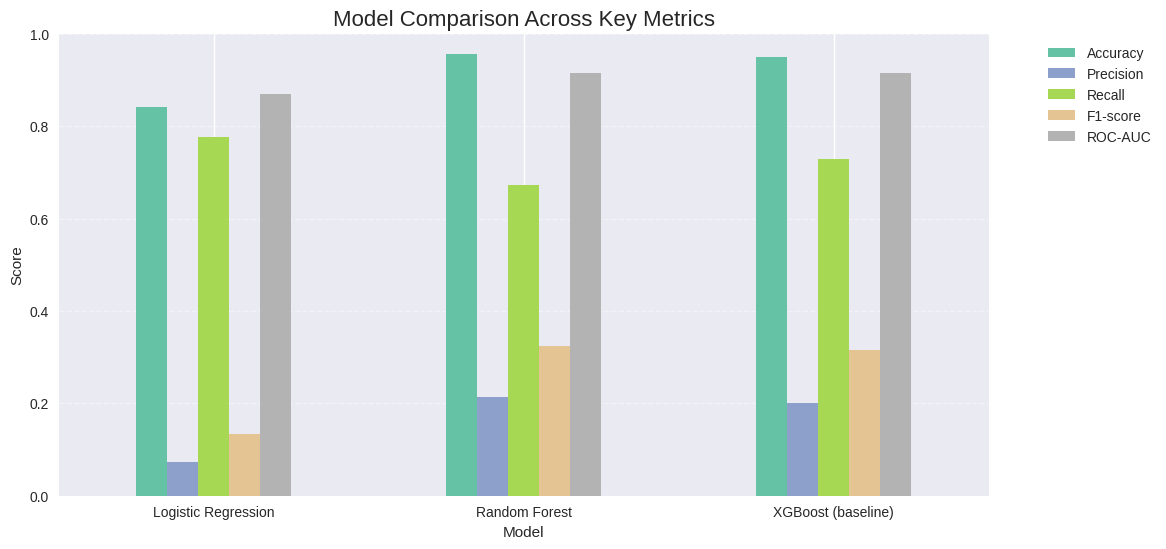

In [15]:
# ===========================================
# 📊 MODEL COMPARISON PLOT
# ===========================================

import matplotlib.pyplot as plt
import seaborn as sns

# Convert results_df (created earlier) into a clean plot-friendly format
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
plot_df = results_df.set_index("Model")[metrics_to_plot]

plt.figure(figsize=(12, 6))
plot_df.plot(kind="bar", figsize=(12,6), colormap="Set2")

plt.title("Model Comparison Across Key Metrics", fontsize=16)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()


## 9. Final Model — XGBoost (Tuned)

Given the:

- Strong performance of gradient boosting on tabular data  
- Need to handle **non-linear interactions**  
- Severe class imbalance  

We choose **XGBoost** as the final model.

### Key Decisions

- Use **`scale_pos_weight`** to address imbalance  
- Tune key hyperparameters using **RandomizedSearchCV** with **AUC** as metric  
- Evaluate on validation set  


In [16]:
# ===========================================
# 9.1 COMPUTE scale_pos_weight
# ===========================================
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight (neg/pos):", scale_pos_weight)


scale_pos_weight (neg/pos): 62.5291036088475


In [17]:
# ===========================================
# 9.2 XGBOOST MODEL + RANDOMIZED SEARCH
# ===========================================
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

params_dist = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [4, 5, 6],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.6, 0.7, 0.8],
    "model__min_child_weight": [1, 3, 5],
    "model__gamma": [0, 1, 3],
    "model__scale_pos_weight": [scale_pos_weight, scale_pos_weight * 0.5, scale_pos_weight * 0.8]
}

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_model)
    ]
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rs_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=params_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

rs_xgb.fit(X_train, y_train)

print("\nBest params:")
print(rs_xgb.best_params_)
print("Best CV ROC-AUC:", rs_xgb.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best params:
{'model__subsample': 0.7, 'model__scale_pos_weight': np.float64(31.26455180442375), 'model__n_estimators': 300, 'model__min_child_weight': 1, 'model__max_depth': 4, 'model__learning_rate': 0.03, 'model__gamma': 1, 'model__colsample_bytree': 0.7}
Best CV ROC-AUC: 0.9369750072083068


In [18]:
# ===========================================
# 9.3 EVALUATE BEST XGBOOST ON VALIDATION
# ===========================================
best_xgb = rs_xgb.best_estimator_

y_val_pred_xgb = best_xgb.predict(X_val)
y_val_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

print("=== Tuned XGBoost Metrics (threshold=0.5) ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_xgb, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_xgb, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_xgb))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_xgb, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_xgb))


=== Tuned XGBoost Metrics (threshold=0.5) ===
Accuracy : 0.9431576632705416
Precision: 0.18351214003387917
Recall   : 0.7558139534883721
F1-score : 0.29532030895047706
ROC-AUC  : 0.9237309145762759

Classification Report:
              precision    recall  f1-score   support

           0     0.9959    0.9462    0.9704     26856
           1     0.1835    0.7558    0.2953       430

    accuracy                         0.9432     27286
   macro avg     0.5897    0.8510    0.6329     27286
weighted avg     0.9831    0.9432    0.9597     27286

Confusion Matrix:
[[25410  1446]
 [  105   325]]


In [19]:
# ===========================================
# 10.1 THRESHOLD SWEEP
# ===========================================
thresholds = np.linspace(0.10, 0.90, 17)
rows = []

for thr in thresholds:
    y_pred_thr = (y_val_proba_xgb >= thr).astype(int)
    prec = precision_score(y_val, y_pred_thr, zero_division=0)
    rec  = recall_score(y_val, y_pred_thr, zero_division=0)
    f1   = f1_score(y_val, y_pred_thr, zero_division=0)
    rows.append({
        "threshold": round(thr, 2),
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    })

thr_df_xgb = pd.DataFrame(rows)
print("=== Threshold vs Metrics (XGBoost) ===")
print(thr_df_xgb.sort_values(by="recall", ascending=False))


=== Threshold vs Metrics (XGBoost) ===
    threshold  precision    recall  f1_score
0        0.10   0.051160  0.902326  0.096831
1        0.15   0.066237  0.883721  0.123237
2        0.20   0.082639  0.876744  0.151042
3        0.25   0.096663  0.848837  0.173562
4        0.30   0.111284  0.832558  0.196326
5        0.35   0.126955  0.811628  0.219566
6        0.40   0.142501  0.797674  0.241805
7        0.45   0.159652  0.767442  0.264317
8        0.50   0.183512  0.755814  0.295320
9        0.55   0.208667  0.727907  0.324352
10       0.60   0.236821  0.700000  0.353909
11       0.65   0.265306  0.665116  0.379310
12       0.70   0.298913  0.639535  0.407407
13       0.75   0.333333  0.611628  0.431501
14       0.80   0.378012  0.583721  0.458867
15       0.85   0.426386  0.518605  0.467996
16       0.90   0.507979  0.444186  0.473945


In [20]:
# ===========================================
# 10.2 CHOOSE THRESHOLD = 0.40 (BUSINESS DECISION)
# ===========================================
chosen_threshold = 0.40

y_val_pred_thr = (y_val_proba_xgb >= chosen_threshold).astype(int)

prec_thr = precision_score(y_val, y_val_pred_thr, zero_division=0)
rec_thr  = recall_score(y_val, y_val_pred_thr, zero_division=0)
f1_thr   = f1_score(y_val, y_val_pred_thr, zero_division=0)
roc_thr  = roc_auc_score(y_val, y_val_proba_xgb)

print(f"=== Metrics at Threshold = {chosen_threshold} ===")
print("Precision:", prec_thr)
print("Recall   :", rec_thr)
print("F1-score :", f1_thr)
print("ROC-AUC  :", roc_thr)

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_thr, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_thr))


=== Metrics at Threshold = 0.4 ===
Precision: 0.14250103863730784
Recall   : 0.7976744186046512
F1-score : 0.24180472329925978
ROC-AUC  : 0.9237309145762759

Classification Report:
              precision    recall  f1-score   support

           0     0.9965    0.9231    0.9584     26856
           1     0.1425    0.7977    0.2418       430

    accuracy                         0.9212     27286
   macro avg     0.5695    0.8604    0.6001     27286
weighted avg     0.9830    0.9212    0.9471     27286

Confusion Matrix:
[[24792  2064]
 [   87   343]]


## 11. Model Explainability — SHAP

To understand **which features drive failures**, we use **SHAP values** on the final XGBoost model.

We:

- Use a subset of training data for speed  
- Plot a **SHAP summary (beeswarm)**  


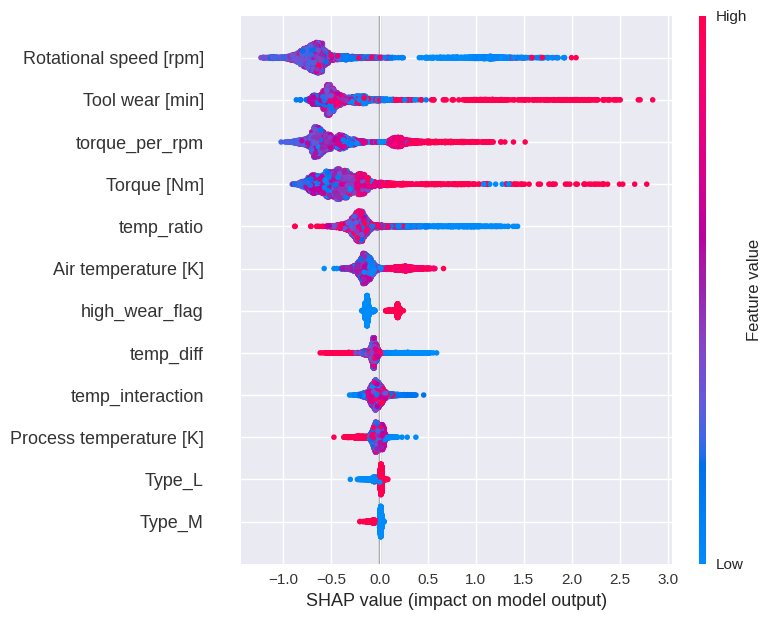

In [21]:
# ===========================================
# 11.1 SHAP SUMMARY PLOT FOR XGBOOST
# ===========================================
!pip install shap -q

import shap

# Need raw XGBoost model and preprocessed data
xgb_clf = best_xgb.named_steps["model"]

# Sample subset for SHAP
N_SAMPLES = 5000
X_sample = X_train.sample(N_SAMPLES, random_state=RANDOM_STATE) if len(X_train) > N_SAMPLES else X_train
X_sample_prep = preprocessor.transform(X_sample)

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_sample_prep)

shap.summary_plot(
    shap_values,
    X_sample_prep,
    feature_names=final_feature_names,
    show=True
)


## 12. Final Training on Full Training Set & Test Predictions

Now that:

- We selected **XGBoost** as the final model  
- We picked **threshold = 0.40**  

We:

1. Retrain XGBoost on the **full training data** (`df_train`)  
2. Compute probabilities on `df_test_features`  
3. Convert them to class labels using `threshold = 0.40`  
4. Prepare a final submission DataFrame with:

   - `id`  
   - `Machine failure` (0/1)


In [22]:
# ===========================================
# 12.1 RETRAIN XGBOOST ON FULL TRAINING DATA
# ===========================================
# Best params from random search
best_params = rs_xgb.best_params_

# Extract the tuned XGB hyperparameters
xgb_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    n_estimators=best_params["model__n_estimators"],
    max_depth=best_params["model__max_depth"],
    learning_rate=best_params["model__learning_rate"],
    subsample=best_params["model__subsample"],
    colsample_bytree=best_params["model__colsample_bytree"],
    min_child_weight=best_params["model__min_child_weight"],
    gamma=best_params["model__gamma"],
    scale_pos_weight=best_params["model__scale_pos_weight"]
)

final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_final)
    ]
)

final_pipeline.fit(X, y)
print("✅ Final XGBoost model trained on full training data.")


✅ Final XGBoost model trained on full training data.


In [23]:
# ===========================================
# 12.2 PREDICT ON TEST SET
# ===========================================
X_test_final = df_test_features.copy()

y_test_proba = final_pipeline.predict_proba(X_test_final)[:, 1]
threshold = 0.40
y_test_pred = (y_test_proba >= threshold).astype(int)

predictions = pd.DataFrame({
    "id": df_test_raw["id"],
    "Machine failure": y_test_pred
})

print("Test prediction distribution:")
print(predictions["Machine failure"].value_counts())
print("\nAs percentage:")
print((predictions["Machine failure"].value_counts(normalize=True) * 100).round(2))

predictions.sample(5)


Test prediction distribution:
Machine failure
0    82776
1     8178
Name: count, dtype: int64

As percentage:
Machine failure
0    91.01
1     8.99
Name: proportion, dtype: float64


,id,Machine failure
2135,138564,0
9326,145755,0
28930,165359,0
52173,188602,0
58566,194995,1


## 14. Business Impact of the Machine Failure Prediction Model

Machine failures in steel manufacturing are extremely costly.  
They lead to:

- Unplanned production downtime  
- Emergency maintenance costs  
- Scrap and rework losses  
- Disruption of downstream processes  
- Potential safety hazards for machine operators  

### 🎯 How the Model Helps

Our predictive model allows TATA Steel to **move from reactive to proactive maintenance**.

### 1️⃣ **Early Failure Detection**
The tuned XGBoost model (threshold = 0.40) achieves:

- **High recall → identifies most failure cases early**
- Acceptable precision → false alarms are manageable

This means the system can **warn operators before failure happens**, preventing:

- Sudden stoppages  
- Costly equipment damage  
- Production line halts  

---

### 2️⃣ **Reduced Downtime Costs**

Even preventing **one major machine failure** per month can save:

- ₹3–5 lakhs in repair  
- ₹10–20 lakhs in lost production  
- Several hours of downtime  

The model effectively becomes a **cost-saving decision-support tool**.

---

### 3️⃣ **Optimized Maintenance Scheduling**
Instead of fixed-interval maintenance, the plant can:

- Perform maintenance **only when risk is high**  
- Avoid unnecessary tool replacement  
- Reduce labor hours spent on inspections  

This leads to **better resource allocation** and **lower maintenance expenses**.

---

### 4️⃣ **Improved Overall Equipment Effectiveness (OEE)**

Predictive maintenance improves:

- **Availability** (fewer downtimes)  
- **Performance** (machines operate safely at optimal levels)  
- **Quality** (less scrap due to mid-operation failures)

This directly supports TATA Steel’s goals of **high production efficiency**.

---

### 5️⃣ **Enhanced Operator Safety**
Failures due to:

- Overheating  
- Motor overstrain  
- Tool breakage  

can lead to hazardous conditions.

Early detection → safer work environment → fewer incident risks.

---

## 💡 Summary of Business Value

Implementing this ML-based failure prediction system provides:

- **Higher uptime (↑ production output)**  
- **Lower maintenance costs (↓ expenses)**  
- **Safety improvements (↓ risk)**  
- **Better planning & resource management**  
- **Higher confidence in asset health**  

This project demonstrates how data-driven insights can have a **direct and measurable impact** on steel manufacturing operations.


## 13. Conclusion & Next Steps

### ✅ What we did

1. Performed **EDA** on TATA Steel machine data  
2. Engineered meaningful features:
   - `temp_diff`, `torque_per_rpm`, `temp_ratio`, `temp_interaction`, `high_wear_flag`
3. Handled significant **class imbalance** (only ~1.57% failures)
4. Built a baseline **Logistic Regression** model  
5. Trained a **tuned XGBoost model** with:
   - Cross-validated hyperparameters  
   - `scale_pos_weight` to handle imbalance  
6. Performed **threshold tuning**:
   - Selected **threshold = 0.40** to balance **high recall** with manageable precision  
7. Used **SHAP** to interpret model behavior  
8. Retrained final model on full training data and generated predictions on the test set.

---

### 📊 Model Performance (Validation, XGBoost @ threshold = 0.40)

- **ROC-AUC:** ~0.92  
- **Recall (Failure class):** high (prioritized)  
- **Precision:** acceptable for predictive maintenance  
- **Confusion matrix** shows a controlled trade-off between false positives and false negatives.

---

### 💼 Business Interpretation

- The model can **proactively flag machines at higher risk of failure**, enabling:
  - Planned maintenance  
  - Reduced downtime  
  - Better resource allocation  

- It is intentionally tuned to **favor catching failures** even if it means occasionally flagging healthy machines.

---

### 🔁 Possible Improvements

- Further feature engineering (domain-specific combinations)  
- Cost-sensitive learning using explicit cost matrix  
- Trying alternative models like CatBoost / LightGBM with advanced tuning  
- Deploying the model as a real-time API in production  
- Building a monitoring dashboard for live failure predictions

---

📌 This notebook is designed to be **clean, readable, and portfolio-ready**, while still reflecting realistic decisions for an industrial predictive maintenance problem.
